# Machine Learning baseline

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from fastcore.basics import Path, AttrDict
from dataset import SPLID
import torch

import os
config = AttrDict(
    challenge_data_dir = Path('~/Projects/splid-comp/dataset').expanduser(),
    valid_ratio = 0.1,
    kernel_size = 5,
    tolerance= 6, # Default evaluation tolerance
)

# Define the directory paths
train_data_dir = config.challenge_data_dir / "train"

# Load the ground truth data
ground_truth = config.challenge_data_dir / 'train_labels.csv'

datalist = []

# Searching for training data within the dataset folder
for file in os.listdir(train_data_dir):
    if file.endswith(".csv"):
        datalist.append(os.path.join(train_data_dir, file))

# Sort the training data and labels
datalist = sorted(datalist, key=lambda i: int(os.path.splitext(os.path.basename(i))[0]))
    

train_datalist, test_datalist = train_test_split(datalist, test_size=0.15)


In [2]:
from datetime import datetime
import torch.nn as nn
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
from models.prectime import PrecTime
from loss import WeightedCELoss

cols = ['Inclination (deg)', 'Longitude (deg)', 'Eccentricity', 'Semimajor Axis (m)', 'RAAN (deg)', 'Argument of Periapsis (deg)', 'Vz (m/s)']
classes = ['SS-CK', 'SS-EK', 'SS-HK', 'SS-NK', 'IK-CK', 'IK-EK', 'IK-HK', 'ID-NK', 'AD-NK']
class_weights = torch.tensor([0.1, 0.1, 0.1, 0.1, 2, 2, 2, 2, 2]).cuda()
trn_data = SPLID(train_datalist, ground_truth, cols, classes=classes)
tst_data = SPLID(test_datalist, ground_truth, cols, classes=classes)

trn_loader = data.DataLoader(trn_data, shuffle=True, batch_size=8)
tst_loader = data.DataLoader(tst_data, shuffle=True, batch_size=8)

lr = 1e-5
n_epochs = 500
best_tst_loss = 1_000_000.

model = PrecTime(len(classes), n_win=92, l_win=24, c_in=len(cols), c_conv=128)
model = model.cuda()
criterion = WeightedCELoss(class_weights=class_weights)
opt = torch.optim.AdamW(model.parameters(), lr=lr)

print('Start model training')

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/splid_trainer_{}'.format(timestamp))

for epoch in range(1, n_epochs + 1):
    
    print('EPOCH {}:'.format(epoch))
    
    running_loss = np.zeros(3)
    last_loss = np.zeros(3)
    model.train(True)
    
    for i, (x_batch, y_batch) in enumerate(trn_loader):
        
        x_batch = x_batch.cuda()
        y_batch = y_batch.cuda()
        # sched.step()
        opt.zero_grad()
        fine_out, coarse_out = model(x_batch)
        tot_loss, fine_loss, coarse_loss = criterion(fine_out, coarse_out, y_batch)
        tot_loss.backward()
        opt.step()
        
        running_loss += np.array([tot_loss.cpu().item(), fine_loss.cpu().item(), coarse_loss.cpu().item()])
        if i % 50 == 49:
            last_loss = running_loss / 50 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss[0]))
            tb_x = epoch * len(trn_loader) + i + 1
            writer.add_scalar('TotLoss/train', last_loss[0], tb_x)
            writer.add_scalar('FineLoss/train', last_loss[1], tb_x)
            writer.add_scalar('CoarseLoss/train', last_loss[2], tb_x)
            running_loss = np.zeros(3)
    
    running_tst_loss = np.zeros(3)
    model.eval()
    
    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(tst_loader):
            x_batch = x_batch.cuda()
            y_batch = y_batch.cuda()
            fine_out, coarse_out = model(x_batch)
            tot_tst_loss, fine_tst_loss, coarse_tst_loss = criterion(fine_out, coarse_out, y_batch)
            running_tst_loss += np.array([tot_tst_loss.cpu(), fine_tst_loss.cpu(), coarse_tst_loss.cpu()])
    
    avg_tst_loss = running_tst_loss / (i + 1)
    print('LOSS train {} valid {}'.format(last_loss[0], avg_tst_loss[0]))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Total Loss',
                    { 'Training' : last_loss[0], 'Validation' : avg_tst_loss[0] },
                    epoch)
    writer.add_scalars('Training vs. Validation Fine Loss',
                    { 'Training' : last_loss[1], 'Validation' : avg_tst_loss[1] },
                    epoch)
    writer.add_scalars('Training vs. Validation Coarse Loss',
                    { 'Training' : last_loss[2], 'Validation' : avg_tst_loss[2] },
                    epoch)
    writer.flush()
    
    # Track best performance, and save the model's state
    if avg_tst_loss[0] < best_tst_loss:
        best_tst_loss = avg_tst_loss[0]
        model_path = 'model_{}.pth'.format(timestamp)
        torch.save(model.state_dict(), 'saved_models/' + model_path)



Loading 1615 files...
Loaded file 0 of 1615
Loaded file 50 of 1615
Loaded file 100 of 1615
Loaded file 150 of 1615
Loaded file 200 of 1615
Loaded file 250 of 1615
Loaded file 300 of 1615
Loaded file 350 of 1615
Loaded file 400 of 1615
Loaded file 450 of 1615
Loaded file 500 of 1615
Loaded file 550 of 1615
Loaded file 600 of 1615
Loaded file 650 of 1615
Loaded file 700 of 1615
Loaded file 750 of 1615
Loaded file 800 of 1615
Loaded file 850 of 1615
Loaded file 900 of 1615
Loaded file 950 of 1615
Loaded file 1000 of 1615
Loaded file 1050 of 1615
Loaded file 1100 of 1615
Loaded file 1150 of 1615
Loaded file 1200 of 1615
Loaded file 1250 of 1615
Loaded file 1300 of 1615
Loaded file 1350 of 1615
Loaded file 1400 of 1615
Loaded file 1450 of 1615
Loaded file 1500 of 1615
Loaded file 1550 of 1615
Loaded file 1600 of 1615
Joining dataframes...
Done!
Loading 285 files...
Loaded file 0 of 285
Loaded file 50 of 285
Loaded file 100 of 285
Loaded file 150 of 285
Loaded file 200 of 285
Loaded file 250

KeyboardInterrupt: 

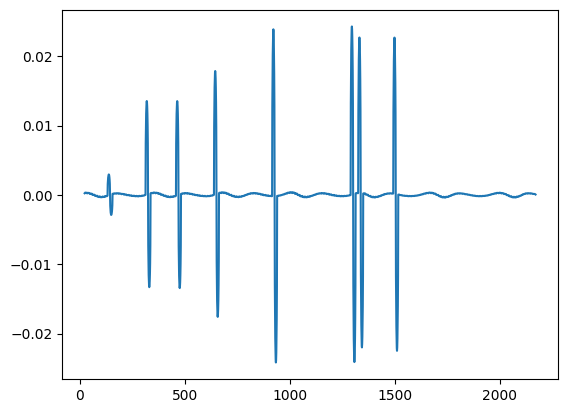

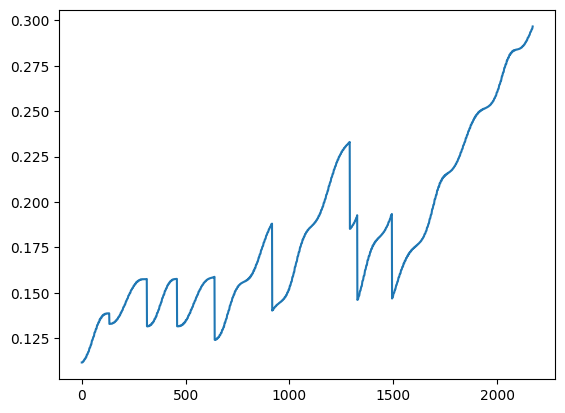

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
df = pd.read_csv('../dataset/train/1004.csv')

plt.plot(df['Inclination (deg)'].rolling(12).std().diff(12))
plt.figure()
plt.plot(df['Inclination (deg)'])